In [14]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

from metrics import get_acc, get_jsd, get_auc


In [15]:
preds = {}
shared_name = "shared_new_3"
test_name = "test_new_3"
model_names = ["weak_base", "weak_ft", "strong_base", "w2s", "strong_ft"]
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "hellaswag", "sciq", "piqa", "sst2", "twitter-sentiment"]
datasplits = ["test"] #["train", "val", "test"]

for dname in datasets:
    print(f"Dataset: {dname}")
    preds[dname] = {}
    for mname in model_names:
        print(f"Model: {mname}")
        preds[dname][mname] = {}
        mfilename = mname
        if mname.endswith("ft"):
            mfilename = mname[:-3]
        folder_name = test_name if mname == "w2s" else shared_name
        for split in datasplits:
            preds[dname][mname][split] = Dataset.from_file(f"results/{folder_name}/{dname}/{mfilename}/predictions/{split}/data-00000-of-00001.arrow")
            print(f"Loaded {len(preds[dname][mname][split])} examples for {split} split, accuracy: {get_acc(preds[dname][mname][split]):.2f}%, auc: {get_auc(preds[dname][mname][split]):.2f}")

Dataset: anli-r2
Model: weak_base
Loaded 668 examples for test split, accuracy: 50.75%, auc: 0.53
Model: weak_ft
Loaded 668 examples for test split, accuracy: 57.63%, auc: 0.62
Model: strong_base
Loaded 668 examples for test split, accuracy: 51.65%, auc: 0.53
Model: w2s
Loaded 668 examples for test split, accuracy: 66.62%, auc: 0.70
Model: strong_ft
Loaded 668 examples for test split, accuracy: 73.35%, auc: 0.79
Dataset: boolq
Model: weak_base
Loaded 2474 examples for test split, accuracy: 63.10%, auc: 0.71
Model: weak_ft
Loaded 2474 examples for test split, accuracy: 76.72%, auc: 0.84
Model: strong_base
Loaded 2474 examples for test split, accuracy: 66.33%, auc: 0.73
Model: w2s
Loaded 2474 examples for test split, accuracy: 82.13%, auc: 0.89
Model: strong_ft
Loaded 2474 examples for test split, accuracy: 87.67%, auc: 0.94
Dataset: cola
Model: weak_base
Loaded 644 examples for test split, accuracy: 72.36%, auc: 0.78
Model: weak_ft
Loaded 644 examples for test split, accuracy: 76.09%, a

### Accuracies of the models across datasets -- grouped bar plot

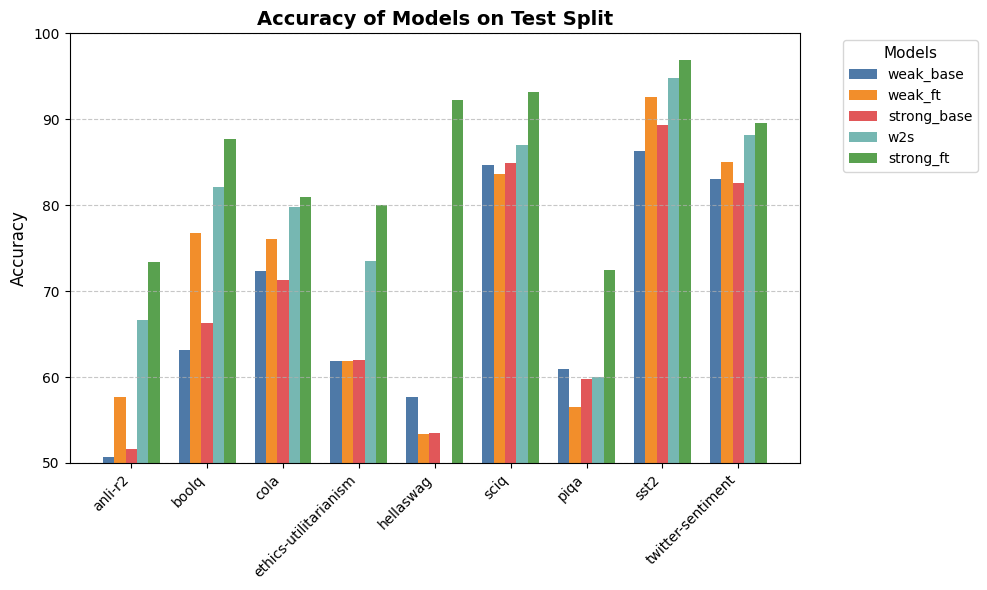

In [16]:
def grouped_bar_plot_accs(preds, exclude_split='test'):
    fig, ax = plt.subplots(figsize=(10, 6))
    barWidth = 0.15  # Narrower bars for better spacing
    r = range(len(datasets))
    
    # Define colors for each model
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']
    
    for i, mname in enumerate(model_names):
        accs = [get_acc(preds[dname][mname][split]) for dname in datasets]
        ax.bar([x + barWidth * i for x in r], accs, width=barWidth, color=colors[i], label=mname)
    
    # Customize ticks and labels
    ax.set_xticks([x + barWidth * (len(model_names) - 1) / 2 for x in r])
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(range(0, 110, 10))
    
    # Set labels and title with larger font sizes
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title(f"Accuracy of Models on {split.capitalize()} Split", fontsize=14, fontweight='bold')
    ax.set_ylim(50, 100)
    
    # Add grid lines for y-axis
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Move legend outside of the plot
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='11')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function
grouped_bar_plot_accs(preds)

In [ ]:
# confusion matrix of weak_ft, strong_base with accuracies of w2s printed in each square along with totals

def conf_mat_accs(dset_preds):
    num_datasets = len(dset_preds)
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    
    # Loop through each dataset and its corresponding axis for subplots
    for idx, (dset, ax) in enumerate(zip(dset_preds, axes)):
        dsref1, dsref2, dsmain = dset_preds[dset][m1name], dset_preds[dset][m2name], dset_preds[dset][m3name]
        dsref1, dsref2, dsmain = add_preds(dsref1), add_preds(dsref2), add_preds(dsmain)
        
        # Calculate accuracy buckets
        buckets = acc_buckets(dsref1, dsref2, dsmain)
        
        # Extract correct and total values
        correct_cc, total_cc = buckets['cc']['correct'], buckets['cc']['total']
        correct_cw, total_cw = buckets['cw']['correct'], buckets['cw']['total']
        correct_wc, total_wc = buckets['wc']['correct'], buckets['wc']['total']
        correct_ww, total_ww = buckets['ww']['correct'], buckets['ww']['total']
        
        # Normalized confusion matrix
        cm = np.array([
            [correct_cc / total_cc if total_cc > 0 else 0, correct_cw / total_cw if total_cw > 0 else 0],
            [correct_wc / total_wc if total_wc > 0 else 0, correct_ww / total_ww if total_ww > 0 else 0]
        ])
        
        # Create text annotations with only total count in brackets
        cm_text = np.array([
            [f"({total_cc})" if total_cc > 0 else "",
             f"({total_cw})" if total_cw > 0 else ""],
            [f"({total_wc})" if total_wc > 0 else "",
             f"({total_ww})" if total_ww > 0 else ""]
        ])
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Correct", "Wrong"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        
        # Add custom text annotations slightly below default text
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i + 0.2, cm_text[i, j], ha="center", va="center", color="black")  # Offset y-position slightly

        # Set dataset title and custom axis labels
        ax.set_title(dset)
        ax.set_xlabel("Weak Fine-Tune Prediction")
        ax.set_ylabel("Strong Base Prediction")
    
    # Adjust layout to fit all subplots well
    plt.tight_layout()
    plt.show()

# Run the function with your data
conf_mat_accs(dset_preds)


In [ ]:
# plot diff metrics: jsd, pred-diff%, kappa grouped bar plot for weak_ft-strong_base, strong_base-w2s, weak-w2s


In [ ]:
# jsd visualized as triangles

In [ ]:
# plot diff metrics: jsd, pred-diff%, kappa vs accuracy gain of w2s model scatter plot across models and datasets

In [ ]:
# linear regression of weak_ft, strong_base probabilities on w2s probabilities